First, importing all the required modules.

In [4]:
import os
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
import nltk
from nltk.corpus import stopwords
import os
import math
from functools import reduce
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from zipfile import ZipFile

### 1. Loading data

The dataset used for this project is stored in the 'archive' directory. Texts by each author are stored in a corresponding folder within it. Let's unzip the folder and take a look at the authors.

In [9]:
with ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

authors_list = [name for name in os.listdir('archive')]
authors_list

['Blok',
 'Chekhov',
 'Dostoevsky',
 'Gogol',
 'Gorky',
 'Pushkin',
 'Tolstoy',
 'Turgenev']

Each directory contains a number of .txt files. I will read them and store them in a dictionary:
```
{author1: [text1, text2, ...], author2: [text1, text2, ...]}
```

Also, I will create a list containing all texts by all authors ('total_texts')

In [3]:
home_path = os.getcwd()

author_text_dict = {}
total_texts = []

for name in authors_list:
    texts_by_author = []
    os.chdir(home_path)
    os.chdir('archive\\'+name)
    for file in os.listdir():
        text = open(file, 'r', encoding='utf-8').read()
        texts_by_author.append(text)
        total_texts.append(text)
    author_text_dict[name] = texts_by_author

### 2. Preprocessing text

To analalyze the data, I will need to clean the texts using regular expressions from any unwanted words and symbols, which in this case include the names of authors, chapter and part numbers, footnotes, page numbers, as well as punctuation. I will not be removing stopwords at this stage for the accuracy of the TF-IDF calculations.

In [4]:
def preprocessor(text):
    '''Text preprocessing function using regular expressions.
    Cleaning the text from the names of the authors, chapter numbers,
    Roman numbers, page numbers, footnotes, and punctuation. 
    Lowercasing the text.'''
    import re
    text = text.replace("Лев Николаевич Толстой", " ").replace("Лев Толстой", " ").replace("Часть первая", " ").\
        replace("Часть вторая", " ").replace("Часть третья", " ").replace("Часть четвертая", " ").\
        replace("ЧАСТЬ ПЕРВАЯ", " ").replace("ЧАСТЬ ВТОРАЯ", " ").replace("ЧАСТЬ ТРЕТЬЯ", " ").\
        replace("ЧАСТЬ ЧЕТВЕРТАЯ", " ").replace("Антон Чехов", " ").replace("Примечания", " ").\
        replace("Николай Гоголь", " ").replace("Николай Васильевич Гоголь", " ").replace("Максим Горький", " ").\
        replace("М. ГОРЬКИЙ", " ").replace("Александр Сергеевич Пушкин", " ").replace("Александр Пушкин", " ").\
        replace("Иван Сергеевич Тургенев", " ").replace("Иван Тургенев", " ").replace("Федор Михайлович Достоевский", " ")
        
    text = re.sub(r"(Глава|ГЛАВА|Том|ТОМ) \S+", " ", text)
    text = re.sub(r"--+", "-", text)
    text = re.sub(r"\**\[.*\]", " ", text)
    text = re.sub(r"\[.*\]", " ", text)
    text = re.sub(r"{.*}", " ", text)
    text = re.sub(r"Стр\..+\n", " ", text)
    text = re.sub(r"[IVXL]+", " ", text)
    text = re.sub(r" - ", " ", text)
    text = re.sub(r"[А-Я]\. *[А-Я]\. [А-Я]\S+", " ", text)
    text = re.sub(r"<<.+>>", " ", text)
    text = re.sub(r"[!@#$%\^\&\*()_=+\?\!:;\",\.»«—]", " ", text)
    text = re.sub(r"\n+", " ", text)
    text = re.sub(r"\s\s*", " ", text)
    text = text.lower()
    return text


Applying the preprocessing function to the loaded data.

In [5]:
clean_author_text_dict = {}
clean_total_texts = []

for author in author_text_dict:
    clean_texts_by_author = []
    for text in author_text_dict[author]:
        clean_text = preprocessor(text)
        clean_texts_by_author.append(clean_text)
        clean_total_texts.append(clean_text)
    clean_author_text_dict[author] = clean_texts_by_author

### 3. Extracting bigrams and creating functions for TF-IDF calculations

The formula for calculating the bigram TF-IDF for each author will be the following:

$$TF_{bigram} = {bigram\ frequency\ in\ document \over document\ length}$$

$$IDF_{bigram} = log{total\ documents \over documents\ with\ bigram}$$

$$TFIDF_{bigram} = TF_{bigram} * IDF_{bigram}$$


In [7]:
# Adding some stopwords to the downloaded nltk's stopwords list

stops = set(stopwords.words('russian') + ["этот", "весь", "свой", "мой", "наш", "их", "ее", "его", "ваш", "твой", "каждый", \
                                          "который", "первый", "второй", "третий", "четвертый", "пятый", "шестой",\
                                         "седьмой", "восьмой", "девятый", "десятый", "какой", "некоторый", "какой-то", "сей",\
                                         "св", "последний", "самый", "всякий", "этакий", "эдакий", "крайний", "следующий"])


def bigram_freq_one_doc(tokenized_text):
  '''Accepts a tokenized text and finds 
  ADJECTVE+NOUN bigrams in it by doing 
  morphological parsing with pymorphy
  analyzer, skipping bigrams containing 
  stopwords, returning a dictionary 
  {normalized bigram: num of appearances}
  '''
  bigram_freq_dict = {}
  text_length = len(tokenized_text)
  for i in range(text_length-1):
      if morph.parse(tokenized_text[i])[0].tag.POS == "ADJF" and morph.parse(tokenized_text[i])[0].normal_form not in stops \
              and morph.parse(tokenized_text[i+1])[0].tag.POS == "NOUN" and morph.parse(tokenized_text[i+1])[0].normal_form not in stops:
          bigram = (morph.parse(tokenized_text[i])[0].normal_form, morph.parse(tokenized_text[i + 1])[0].normal_form)
          if bigram not in bigram_freq_dict:
              bigram_freq_dict[bigram] = 0
          bigram_freq_dict[bigram] += 1

  return bigram_freq_dict

def bigram_doc(bigram_freq_dicts):
    '''Accepts a list of dictionaries created with
    bigram_freq_one_doc function (dictionaries of bigram
    frequences) and counts the number of docs it
    appears in, returning a dictionary
    {bigram: number of docs}
    '''
    bigram_doc_counter = {}
    for bigram_dict in bigram_freq_dicts:
        for bigram in bigram_dict:
            if bigram not in bigram_doc_counter:
                bigram_doc_counter[bigram] = 0
            bigram_doc_counter[bigram] += 1

    return bigram_doc_counter

def merge_bigram_freq_dicts(bigram_freq_dicts):
    '''Accepts a list of dictionaries created with
    bigram_freq_one_doc function (dictionaries of bigram
    frequences) and summarizes frequencies,
    returning a single dictionary of bigram
    frequencies for one author
    '''
    merged_bigram_freq_dict = {}
    for bigram_dict in bigram_freq_dicts:
        for bigram in bigram_dict.keys():
            merged_bigram_freq_dict[bigram] = merged_bigram_freq_dict.get(bigram, 0) + bigram_dict[bigram]

    return merged_bigram_freq_dict

def bigram_tf(merged_bigram_freq_dict, text_length):
    '''Accepts a single dictionary of bigram frequences
    created with merged_bigram_freq_dicts function
    and calculates bigram TFs by dividing the values
    by the total length of texts by one author,
    returning a dictionary {bigram: tf}
    '''
    bigram_tf_dict = {}
    for bigram in merged_bigram_freq_dict:
        tf_bigram = merged_bigram_freq_dict[bigram] / text_length
        bigram_tf_dict[bigram] = tf_bigram
    return bigram_tf_dict

def bigram_idf(bigram_doc_counter, num_docs):
    '''Accepts a dictionary created with 
    bigram_doc_counter function {bigram: num of docs}
    and a total number of docs for all authors
    and calculates IDFs, returning a dictionary
    {bigram: idf}
    '''
    bigram_idf_dict = {}
    for bigram in bigram_doc_counter:
        bigram_idf_dict[bigram] = math.log(num_docs / bigram_doc_counter[bigram])
    return bigram_idf_dict

def make_bigram_tfidf_dict(clean_author_text_dict):
    '''Accepts a dictionary containing lists of preprocessed texts (value)
    by author (key) and, utilizing the previously created functions,
    extracts bigrams and calculates TF*IDF for each,
    returning a dictionary {author1: {bigram1: tfidf1}, ...}
    '''
    bigram_tfidf_by_author = {}
    num_docs = reduce(lambda x,y: x + len(y), list(clean_author_text_dict.values()), 0)
    for author in clean_author_text_dict:
        text_length = len((' '.join(clean_author_text_dict[author])).split())
        bigram_freq_dicts = [bigram_freq_one_doc(text.split()) for text in clean_author_text_dict[author]]
        bigram_doc_counter = bigram_doc(bigram_freq_dicts)
        merged_bigram_freq_dict = merge_bigram_freq_dicts(bigram_freq_dicts)
        bigram_tf_dict = bigram_tf(merged_bigram_freq_dict, text_length)
        bigram_idf_dict = bigram_idf(bigram_doc_counter, num_docs)
        bigram_tfidf = {bigram: bigram_tf_dict[bigram] * bigram_idf_dict[bigram] for bigram in set(bigram_tf_dict)}
        bigram_tfidf = dict(sorted(bigram_tfidf.items(), key=lambda x:x[1], reverse=True))
        bigram_tfidf_by_author[author] = bigram_tfidf
    
    return bigram_tfidf_by_author

In [8]:
bigram_tfidf_by_author = make_bigram_tfidf_dict(clean_author_text_dict)

In [9]:
list(bigram_tfidf_by_author.items())[0]

('Blok',
 {('бессмертный', 'душа'): 0.0052926062562258175,
  ('муравьиный', 'царь'): 0.0052926062562258175,
  ('розовый', 'калитка'): 0.0026463031281129088,
  ('домовый', 'комитет'): 0.0026463031281129088,
  ('безобразный', 'карлик'): 0.0026463031281129088,
  ('золотой', 'змея'): 0.001764202085408606,
  ('тусклый', 'солнце'): 0.001764202085408606,
  ('вооружённый', 'гражданин'): 0.001764202085408606,
  ('соседний', 'мужик'): 0.001764202085408606,
  ('русский', 'человек'): 0.001764202085408606,
  ('настоящий', 'человек'): 0.001764202085408606,
  ('тёмный', 'занавесь'): 0.001764202085408606,
  ('стриженый', 'липа'): 0.001764202085408606,
  ('тайный', 'советник'): 0.001764202085408606,
  ('романтический', 'страна'): 0.001764202085408606,
  ('долгий', 'жизнь'): 0.001764202085408606,
  ('бывший', 'вице-губернатор'): 0.001764202085408606,
  ('маленький', 'калитка'): 0.001764202085408606,
  ('зелёный', 'ров'): 0.001764202085408606,
  ('народный', 'просвещение'): 0.001764202085408606,
  ('запа

Next I'll fuse the bigrams into phrases, inflecting the correct gender on each adjective by checking the gender of the noun.

In [10]:
phrase_tfidf_by_author = {}
for author in bigram_tfidf_by_author:
    phrase_tfidf = {}
    for bigram, tfidf in bigram_tfidf_by_author[author].items():
        noun = bigram[1]
        adj = bigram[0]
        try:
            gender = morph.parse(noun)[0].tag.gender    #gender of noun
            new_adj = morph.parse(adj)[0].inflect({gender, 'nomn'}).word
            new_value = new_adj + " " + noun
        except:
            new_value = adj + " " + noun
        phrase_tfidf[new_value] = tfidf
    phrase_tfidf_by_author[author] = phrase_tfidf

In [11]:
list(phrase_tfidf_by_author.items())[0]

('Blok',
 {'бессмертная душа': 0.0052926062562258175,
  'муравьиный царь': 0.0052926062562258175,
  'розовая калитка': 0.0026463031281129088,
  'домовый комитет': 0.0026463031281129088,
  'безобразный карлик': 0.0026463031281129088,
  'золотая змея': 0.001764202085408606,
  'тусклое солнце': 0.001764202085408606,
  'вооружённый гражданин': 0.001764202085408606,
  'соседний мужик': 0.001764202085408606,
  'русский человек': 0.001764202085408606,
  'настоящий человек': 0.001764202085408606,
  'тёмная занавесь': 0.001764202085408606,
  'стриженая липа': 0.001764202085408606,
  'тайный советник': 0.001764202085408606,
  'романтическая страна': 0.001764202085408606,
  'долгая жизнь': 0.001764202085408606,
  'бывший вице-губернатор': 0.001764202085408606,
  'маленькая калитка': 0.001764202085408606,
  'зелёный ров': 0.001764202085408606,
  'народное просвещение': 0.001764202085408606,
  'западная легенда': 0.001764202085408606,
  'небесный расцвет': 0.000882101042704303,
  'странная красота'

### 4. Making wordclouds

In [12]:
def show_wordcloud(phrase_tfidf):
    '''Accepts a dictionary of phrases and their TFIDFs,
    shows a wordcloud generated from it
    '''
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", width=800, height=400)
    wordcloud.generate_from_frequencies(frequencies=phrase_tfidf)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Blok


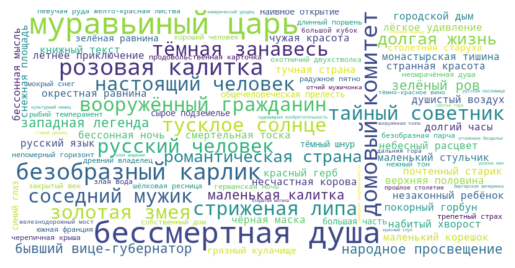

Chekhov


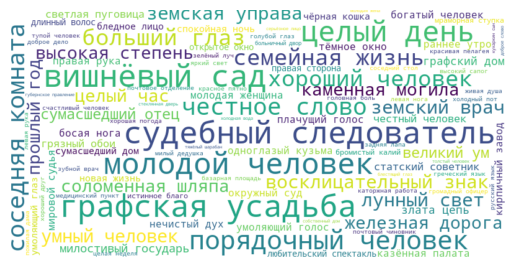

Dostoevsky


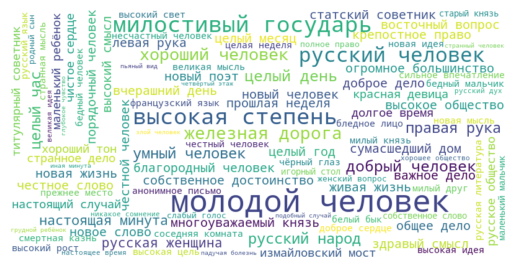

Gogol


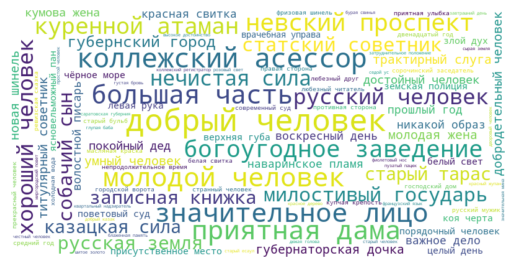

Gorky


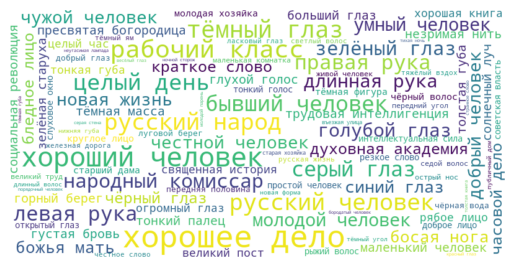

Pushkin


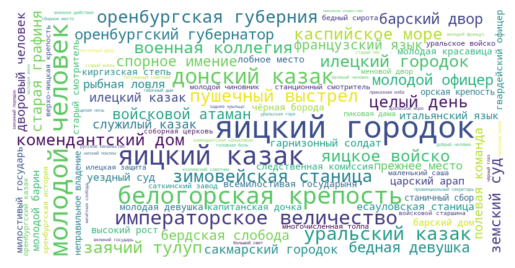

Tolstoy


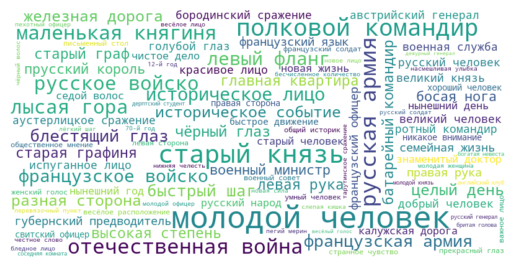

Turgenev


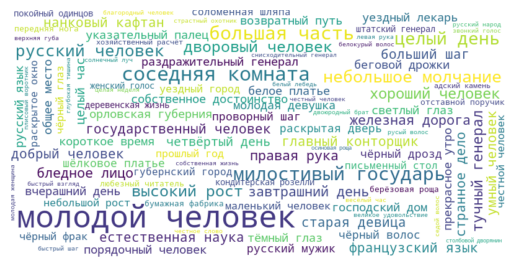

In [13]:
for author in phrase_tfidf_by_author:
    print(author)
    show_wordcloud(phrase_tfidf_by_author[author])